In [1]:
from dataclasses import dataclass, field
import copy
from enum import Enum, auto
import random
import pandas as pd
import seaborn as sns


import blackjack as bj
from blackjack import Hand, HandScore, Action, make_hand

In [2]:
h = HandScore(11, True)
h

s11

In [3]:
h.add_card(10)

s21

In [4]:
h.add_card(10).add_card(10)

h21

In [5]:
h

s11

In [6]:
h.add_card(3)

s14

In [7]:
h.add_card(3).add_card(10)

h14

In [8]:
all_scores = [HandScore(i, False) for i in range(0, 23)] + [HandScore(i, True) for i in range(11, 22)]
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [9]:
h = Hand()
h

Hand(score=h00, cards=[], doubled=False)

In [10]:
h.add_card(6) # start a hand with a 6

Hand(score=h06, cards=[6], doubled=False)

In [11]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=h16, cards=[6, 11], doubled=False)

In [12]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=h22, cards=[6, 11, 7], doubled=False), True)

In [13]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=s11, cards=[1], doubled=False)

In [14]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=s12, cards=[1, 1], doubled=False)

In [15]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=h12, cards=[1, 1, 11], doubled=False)

In [16]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=s21, cards=[1, 10], doubled=False), True)

## Now define gameplay and strategy

In [17]:
[bj.deal_card() for _ in range(10)]

[3, 7, 4, 2, 8, 12, 11, 10, 9, 9]

In [18]:
bj.play_one_round([bj.strat_nobust, bj.strat_nobust])

[('strat_nobust',
  Hand(score=h12, cards=[4, 8], doubled=False),
  Hand(score=s18, cards=[1, 7], doubled=False),
  <HandOutcome.LOSE: -1>),
 ('strat_nobust',
  Hand(score=h12, cards=[4, 8], doubled=False),
  Hand(score=s18, cards=[1, 7], doubled=False),
  <HandOutcome.LOSE: -1>)]

## Aggregate and summarize the data from the simulations

In [19]:

def generate_row_from_player(player):
    (strat, hand_p, hand_d, outcome) = player
    return {'strategy': strat, 'hand_start': hand_p.cards[:2], 'dealer_card': hand_d.cards[0], 'hand_end': hand_p.cards, 'dealer_hand': hand_d.cards, 'outcome': outcome}

def generate_rows_from_round(r):
    return [generate_row_from_player(player) for player in r]

strat_nobust = bj.strat_nobust
strat_dealer = bj.strat_dealer
generate_rows_from_round(bj.play_one_round([bj.strat_nobust, bj.strat_dealer]))


[{'strategy': 'strat_nobust',
  'hand_start': [1, 13],
  'dealer_card': 2,
  'hand_end': [1, 13],
  'dealer_hand': [2, 7, 8],
  'outcome': <HandOutcome.BLACKJACK: 1.5>},
 {'strategy': 'strat_dealer',
  'hand_start': [1, 13],
  'dealer_card': 2,
  'hand_end': [1, 13],
  'dealer_hand': [2, 7, 8],
  'outcome': <HandOutcome.BLACKJACK: 1.5>}]

In [20]:
def run_n_sim_trials(strats, n):
    sims = [generate_rows_from_round(bj.play_one_round(strats)) for _ in range(n)]
    results = pd.DataFrame([player for round in sims for player in round])
    results['outcome_value'] = results['outcome'].apply(lambda x: x.value)
    results['outcome_name'] = results['outcome'].apply(lambda x: str(x)[12:])
    return results

def summarize_totals(sims):
    def outcome_name(x): return x.head(1) # The function name will be used as the column name
    outcome_counts = sims.groupby(['strategy', 'outcome_value'])['outcome_name'].agg([len, outcome_name])
    outcome_summary = outcome_counts.reset_index().set_index('strategy').drop(['outcome_value'], axis=1).pivot(columns=['outcome_name'])

    # The empty cells are NaNs; fill the NaNs and convert back to int
    for col in outcome_summary.columns:
        outcome_summary[col] = outcome_summary[col].fillna(0).apply(int)
        
    outcome_summary['mean_outcome'] = sims.groupby('strategy')['outcome_value'].mean()
    
    return outcome_summary


sim_results = run_n_sim_trials([strat_nobust, strat_dealer], 1000)
sim_results, summarize_totals(sim_results)

(          strategy hand_start  dealer_card          hand_end    dealer_hand  \
 0     strat_nobust    [8, 13]           12           [8, 13]  [12, 5, 1, 9]   
 1     strat_dealer    [8, 13]           12           [8, 13]  [12, 5, 1, 9]   
 2     strat_nobust     [5, 1]            2            [5, 1]  [2, 4, 5, 13]   
 3     strat_dealer     [5, 1]            2  [5, 1, 6, 4, 12]  [2, 4, 5, 13]   
 4     strat_nobust    [5, 11]            8           [5, 11]         [8, 1]   
 ...            ...        ...          ...               ...            ...   
 1995  strat_dealer    [3, 12]           10        [3, 12, 5]        [10, 8]   
 1996  strat_nobust     [9, 9]            8            [9, 9]      [8, 5, 7]   
 1997  strat_dealer     [9, 9]            8            [9, 9]      [8, 5, 7]   
 1998  strat_nobust     [9, 1]            3            [9, 1]    [3, 11, 11]   
 1999  strat_dealer     [9, 1]            3            [9, 1]    [3, 11, 11]   
 
                outcome  outcome_value

In [21]:
def strat_simple(score_p, score_d):
    if score_p.points == 11:  return Action.DOUBLE
    if score_p.points >= 17:  return Action.STAND
    if score_p.points <= 11:  return Action.HIT
    if score_d.points in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple.name = 'simple'


sims = run_n_sim_trials([strat_simple], 1000)
sims.head(10), summarize_totals(sims)

(  strategy hand_start  dealer_card    hand_end      dealer_hand  \
 0   simple     [2, 5]            3   [2, 5, 9]    [3, 9, 3, 11]   
 1   simple    [3, 10]            7  [3, 10, 7]       [7, 2, 10]   
 2   simple     [4, 7]            8  [4, 7, 12]       [8, 8, 12]   
 3   simple    [10, 9]            4     [10, 9]  [4, 2, 4, 5, 8]   
 4   simple    [4, 12]            6     [4, 12]        [6, 9, 6]   
 5   simple     [3, 6]            6   [3, 6, 4]      [6, 10, 12]   
 6   simple     [7, 3]            5  [7, 3, 10]     [5, 7, 3, 4]   
 7   simple     [7, 7]           13   [7, 7, 3]       [13, 5, 4]   
 8   simple     [9, 4]           13  [9, 4, 12]       [13, 5, 6]   
 9   simple     [7, 4]           11   [7, 4, 7]          [11, 9]   
 
                    outcome  outcome_value outcome_name  
 0          HandOutcome.WIN            1.0          WIN  
 1          HandOutcome.WIN            1.0          WIN  
 2   HandOutcome.WIN_DOUBLE            2.0   WIN_DOUBLE  
 3          HandOu

In [22]:
summarize_totals(run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10000))


len                                         mean_outcome
outcome_name BLACKJACK  LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                                   
simple             444  4673         246  830  3494        313      -0.0379
strat_dealer       444  4910           0  936  3710          0      -0.0534
strat_nobust       444  5165           0  617  3774          0      -0.0725

## Simulate specific situations to determine strategy

In [23]:
# 12 vs deuce

hand_p = make_hand([5, 7])
hand_d = make_hand([2])

hand_p, hand_d

(Hand(score=h12, cards=[5, 7], doubled=False),
 Hand(score=h02, cards=[2], doubled=False))

In [24]:
# Implement a strategy that composes conditions and actions

def cond_12_2(score_p, score_d):
    return score_p.points == 12 and score_d.points == 2 and not score_p.soft
conditions = [(cond_12_2, Action.STAND)]

def generate_strat_conditional(strat_base, conditions):
    def strat_cond(score_p, score_d):
        for (condition, action) in conditions:
            if condition(score_p, score_d): return action
        return strat_base(score_p, score_d)
    strat_cond.name = 'strat_cond'
    return strat_cond
    
strat_cond = generate_strat_conditional(strat_simple, conditions)

In [25]:
def gen_cond_strategies(strat_base, condition, actions):
    def gen_strat_action(strat_base, condition, action):
        strat = generate_strat_conditional(strat_base, [(condition, action)])
        strat.name = repr(action)
        return strat
    
    strats = [gen_strat_action(strat_base, condition, a) for a in actions]
    return strats
    



strats = gen_cond_strategies(strat_simple, cond_12_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>]

In [26]:
bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())

[('<Action.HIT: 2>',
  Hand(score=h22, cards=[5, 7, 12], doubled=False),
  Hand(score=s18, cards=[2, 5, 1], doubled=False),
  <HandOutcome.LOSE: -1>),
 ('<Action.STAND: 1>',
  Hand(score=h12, cards=[5, 7], doubled=False),
  Hand(score=s18, cards=[2, 5, 1], doubled=False),
  <HandOutcome.LOSE: -1>),
 ('<Action.DOUBLE: 3>',
  Hand(score=h14, cards=[5, 7, 2], doubled=True),
  Hand(score=s18, cards=[2, 5, 1], doubled=False),
  <HandOutcome.LOSE_DOUBLE: -2>)]

In [27]:
# TODO reduce duplication with run_n_sim_trials
def run_n_sim_trials_from_state(strats, hand_p, hand_d, n):
    sims = [generate_rows_from_round(bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())) for _ in range(n)]
    results = pd.DataFrame([player for round in sims for player in round])
    results['outcome_value'] = results['outcome'].apply(lambda x: x.value)
    results['outcome_name'] = results['outcome'].apply(lambda x: str(x)[12:])
    return results

sims = run_n_sim_trials_from_state(strats, hand_p, hand_d, 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5950  444     0       3606      -0.4688
<Action.HIT: 2>     6063           0  632  3305          0      -0.2758
<Action.STAND: 1>   6312           0    0  3688          0      -0.2624

In [28]:
# Soft 12 vs 2
hand_12s = make_hand([1, 1])

hand_12s, hand_d

(Hand(score=s12, cards=[1, 1], doubled=False),
 Hand(score=h02, cards=[2], doubled=False))

In [29]:
def cond_12s_2(score_p, score_d):
    return score_p == HandScore(12, True) and score_d.points == 2

strats = gen_cond_strategies(strat_simple, cond_12s_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>]

In [30]:
sims = run_n_sim_trials_from_state(strats+[strat_simple], hand_12s, hand_d, 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        6335    0     0       3665      -0.5340
<Action.HIT: 2>     4817         428  746  3281        728      -0.0936
<Action.STAND: 1>   6335           0    0  3665          0      -0.2670
simple              4836         401  762  3290        711      -0.0926

In [31]:
summarize_totals(run_n_sim_trials_from_state([strat_simple, strat_cond], hand_p, hand_d, 10*1000))

len            mean_outcome
outcome_name  LOSE PUSH   WIN             
strategy                                  
simple        6124  702  3174      -0.2950
strat_cond    6397    0  3603      -0.2794

In [32]:
# soft 13 vs 6
def cond_13s_6(score_p, score_d):
    return score_p == HandScore(13, True) and score_d.points == 6



strats = gen_cond_strategies(strat_simple, cond_13s_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = run_n_sim_trials_from_state(strats+[strat_simple], bj.make_hand([1, 2]), bj.make_hand([6]), 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5790    0     0       4210      -0.3160
<Action.HIT: 2>     4550         327  326  4134        663       0.0256
<Action.STAND: 1>   5790           0    0  4210          0      -0.1580
simple              5790           0    0  4210          0      -0.1580

In [33]:
# 10 v 6
def cond_10_6(score_p, score_d):
    return score_p.points == 10 and score_d.points == 6

strats = gen_cond_strategies(strat_simple, cond_10_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = run_n_sim_trials_from_state(strats+[strat_simple], make_hand([5, 5]), make_hand([6]), 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        3281  667     0       6052       0.5542
<Action.HIT: 2>     3273           0  730  5997          0       0.2724
<Action.STAND: 1>   5883           0    0  4117          0      -0.1766
simple              3360           0  704  5936          0       0.2576

In [34]:
ACTIONS = [Action.HIT, Action.STAND, Action.DOUBLE]

def test_cond(score_p, score_d, n):
    def cond(p, d):
        return p == score_p and d == score_d
    strats = gen_cond_strategies(strat_simple, cond, ACTIONS)
    hand = Hand(score_p) # This will only work for 10 through 18 
    sims = run_n_sim_trials_from_state(strats, hand, make_hand([score_d.points]), n)
    return cond, summarize_totals(sims)

test_cond(HandScore(10), HandScore(6), 10000)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                      len                                   mean_outcome
 outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
 strategy                                                               
 <Action.DOUBLE: 3>     0        3256  680     0       6064       0.5616
 <Action.HIT: 2>     3206           0  658  6136          0       0.2930
 <Action.STAND: 1>   5811           0    0  4189          0      -0.1622)

In [35]:
test_cond(HandScore(18), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         152    7    0         41       -1.110
 <Action.HIT: 2>     160           0    5   35          0       -0.625
 <Action.STAND: 1>    61           0   25  114          0        0.265)

In [36]:
test_cond(HandScore(21, True), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0          72   10    0        118         0.46
 <Action.HIT: 2>      51           0   20  129          0         0.39
 <Action.STAND: 1>     0           0   20  180          0         0.90)

In [38]:
def find_winning_action(score_p, score_d, n):
    cond, summary = test_cond(score_p, score_d, n)
    outcomes = summary['mean_outcome']
    # Find the winning strategy
    winner = outcomes[outcomes==outcomes.max()].index[0]
    winning_act = [a for a in ACTIONS if repr(a)==winner][0]

    # Convert results to a dict
    run = outcomes.to_dict()
    run['score_p'] = repr(score_p)
    run['score_d'] = repr(score_d)
    run['winning_act'] = winning_act
    run['winning_act_outcome'] = outcomes.max()

    return (cond, run)

find_winning_action(HandScore(10), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
 {'<Action.DOUBLE: 3>': 0.6,
  '<Action.HIT: 2>': 0.245,
  '<Action.STAND: 1>': -0.23,
  'score_p': 'h10',
  'score_d': 'h06',
  'winning_act': <Action.DOUBLE: 3>,
  'winning_act_outcome': 0.6})

In [39]:
conds = [find_winning_action(p, make_hand([d]).score, 10) for p in all_scores for d in range(1, 3)]
pd.DataFrame([data for _, data in conds]).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h00     s11                    0.05            -0.20               -1.0   
        h02                   -0.80             0.30               -0.4   
h01     s11                   -0.20             0.10                0.2   
        h02                   -0.40             0.25               -0.2   
h02     s11                    0.25             0.10               -0.4   
...                             ...              ...                ...   
s19     h02                    0.00            -0.15                0.2   
s20     s11                    0.60             0.60                0.6   
        h02                    0.40             0.00                0.6   
s21     s11                    0.30             0.30                0.3   
        h02                   -1.20             0.30                0.8   

                   winning_act  winning_act_outcome  
score_p score_d                                      
h00     s11      Action.DOUBLE                 0.05  
        h02         Action.HIT                 0.30  
h01     s11       Action.STAND                 0.20  
        h02         Action.HIT                 0.25  
h02     s11      Action.DOUBLE                 0.25  
...                        ...                  ...  
s19     h02       Action.STAND                 0.20  
s20     s11      Action.DOUBLE                 0.60  
        h02       Action.STAND                 0.60  
s21     s11      Action.DOUBLE                 0.30  
        h02       Action.STAND                 0.80  

[68 rows x 5 columns]

In [40]:
conds = [find_winning_action(HandScore(p), make_hand([d]).score, 1*1000) for p in range(10, 19) for d in range(1, 11)]
conds

[(<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': -0.0415,
   '<Action.HIT: 2>': -0.0055,
   '<Action.STAND: 1>': -0.015,
   'score_p': 'h10',
   'score_d': 's11',
   'winning_act': <Action.HIT: 2>,
   'winning_act_outcome': -0.0055}),
 (<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': 0.336,
   '<Action.HIT: 2>': 0.156,
   '<Action.STAND: 1>': -0.292,
   'score_p': 'h10',
   'score_d': 'h02',
   'winning_act': <Action.DOUBLE: 3>,
   'winning_act_outcome': 0.336}),
 (<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': 0.462,
   '<Action.HIT: 2>': 0.216,
   '<Action.STAND: 1>': -0.222,
   'score_p': 'h10',
   'score_d': 'h03',
   'winning_act': <Action.DOUBLE: 3>,
   'winning_act_outcome': 0.462}),
 (<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': 0.422,
   '<Action.HIT: 2>': 0.195,
   '<Action.STAND: 1>': -0.23,
   'score_p': 'h10',
   'score_d': 'h04',
   'winning_act': <Action.D

In [41]:
outputs = pd.DataFrame([data for _, data in conds]).set_index(['score_p', 'score_d'])
outputs

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h10     s11                 -0.0415          -0.0055             -0.015   
        h02                  0.3360           0.1560             -0.292   
        h03                  0.4620           0.2160             -0.222   
        h04                  0.4220           0.1950             -0.230   
        h05                  0.4100           0.2810             -0.174   
...                             ...              ...                ...   
h18     h06                 -1.1740          -0.6140              0.222   
        h07                 -1.2000          -0.6260              0.379   
        h08                 -1.2620          -0.6100              0.124   
        h09                 -1.2880          -0.6200             -0.189   
        h10                 -1.3360          -0.6630             -0.203   

                   winning_act  winning_act_outcome  
score_p score_d                                      
h10     s11         Action.HIT              -0.0055  
        h02      Action.DOUBLE               0.3360  
        h03      Action.DOUBLE               0.4620  
        h04      Action.DOUBLE               0.4220  
        h05      Action.DOUBLE               0.4100  
...                        ...                  ...  
h18     h06       Action.STAND               0.2220  
        h07       Action.STAND               0.3790  
        h08       Action.STAND               0.1240  
        h09       Action.STAND              -0.1890  
        h10       Action.STAND              -0.2030  

[90 rows x 5 columns]

<AxesSubplot:xlabel='score_d', ylabel='score_p'>

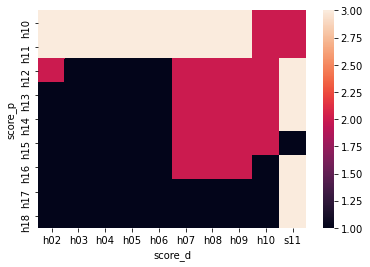

In [42]:
# Visualize the winning action by starting condition
sns.heatmap(outputs['winning_act'].apply(lambda x: x.value).unstack())


<AxesSubplot:xlabel='score_d', ylabel='score_p'>

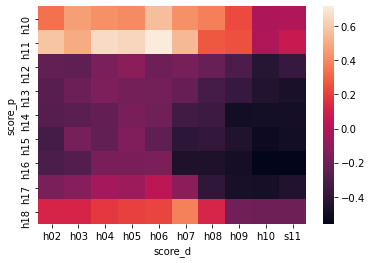

In [43]:
# Visualize the average outcome by starting condition
sns.heatmap(outputs['winning_act_outcome'].unstack())

In [44]:
[(cond, output['winning_act']) for cond, output in conds]

[(<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p,

In [45]:
strat_derived = generate_strat_conditional(strat_simple, [(cond, output['winning_act']) for cond, output in conds])
strat_derived.name = 'strat_derived'

In [46]:
sims = run_n_sim_trials([strat_simple, strat_derived], 100)
sims.head(10), summarize_totals(sims)

(        strategy hand_start  dealer_card      hand_end dealer_hand  \
 0         simple    [5, 12]            7    [5, 12, 7]   [7, 3, 9]   
 1  strat_derived    [5, 12]            7   [5, 12, 12]   [7, 3, 9]   
 2         simple    [11, 9]            2       [11, 9]  [2, 6, 13]   
 3  strat_derived    [11, 9]            2       [11, 9]  [2, 6, 13]   
 4         simple     [3, 6]           11    [3, 6, 13]     [11, 7]   
 5  strat_derived     [3, 6]           11    [3, 6, 12]     [11, 7]   
 6         simple    [8, 11]            9       [8, 11]   [9, 5, 3]   
 7  strat_derived    [8, 11]            9       [8, 11]   [9, 5, 3]   
 8         simple     [4, 9]           13     [4, 9, 8]  [13, 4, 9]   
 9  strat_derived     [4, 9]           13  [4, 9, 1, 4]  [13, 4, 9]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.LOSE           -1.0         LOSE  
 1  HandOutcome.LOSE           -1.0         LOSE  
 2   HandOutcome.WIN            1.0          WIN  
 3   HandOutc

In [47]:
sims = run_n_sim_trials([strat_simple, strat_derived], 100*1000)
sims.head(10), summarize_totals(sims)

(        strategy hand_start  dealer_card    hand_end     dealer_hand  \
 0         simple   [10, 13]           12    [10, 13]        [12, 13]   
 1  strat_derived   [10, 13]           12    [10, 13]        [12, 13]   
 2         simple     [7, 7]            4      [7, 7]  [4, 13, 1, 10]   
 3  strat_derived     [7, 7]            4      [7, 7]  [4, 13, 1, 10]   
 4         simple     [7, 8]           10   [7, 8, 6]         [10, 1]   
 5  strat_derived     [7, 8]           10   [7, 8, 7]         [10, 1]   
 6         simple    [9, 13]            8     [9, 13]          [8, 1]   
 7  strat_derived    [9, 13]            8     [9, 13]          [8, 1]   
 8         simple     [3, 6]           11   [3, 6, 8]         [11, 7]   
 9  strat_derived     [3, 6]           11  [3, 6, 13]         [11, 7]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.PUSH            0.0         PUSH  
 1  HandOutcome.PUSH            0.0         PUSH  
 2   HandOutcome.WIN            1.0       

In [48]:
sims

,strategy,hand_start,dealer_card,hand_end,dealer_hand,outcome,outcome_value,outcome_name
0,simple,"[10, 13]",12,"[10, 13]","[12, 13]",HandOutcome.PUSH,0.0,PUSH
1,strat_derived,"[10, 13]",12,"[10, 13]","[12, 13]",HandOutcome.PUSH,0.0,PUSH
2,simple,"[7, 7]",4,"[7, 7]","[4, 13, 1, 10]",HandOutcome.WIN,1.0,WIN
3,strat_derived,"[7, 7]",4,"[7, 7]","[4, 13, 1, 10]",HandOutcome.WIN,1.0,WIN
4,simple,"[7, 8]",10,"[7, 8, 6]","[10, 1]",HandOutcome.LOSE,-1.0,LOSE
...,...,...,...,...,...,...,...,...
199995,strat_derived,"[10, 8]",6,"[10, 8]","[6, 9, 2]",HandOutcome.WIN,1.0,WIN
199996,simple,"[3, 6]",8,"[3, 6, 2, 5]","[8, 11]",HandOutcome.LOSE_DOUBLE,-2.0,LOSE_DOUBLE
199997,strat_derived,"[3, 6]",8,"[3, 6, 1]","[8, 11]",HandOutcome.WIN,1.0,WIN
199998,simple,"[4, 8]",5,"[4, 8]","[5, 10, 4]",HandOutcome.LOSE,-1.0,LOSE
